
# Week 2 — Exploring Linear and Logistic Regression

In this notebook, I explore key concepts introduced in Week 2 of the *Intro to Machine Learning* course.  
The focus is on implementing and analyzing **linear** and **logistic regression** models using Python and NumPy,  
as well as understanding **gradient descent**, **model fitting**, and **decision boundaries**.


## Setting Up

As usual, this notebook makes use of the NumPy library for numerical computing and the Matplotlib library for plotting, so we need to import them.

In [1]:
pip install numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import numpy.random
import matplotlib
import matplotlib.pyplot as plt

# this is probably the default, but just in case
%matplotlib inline

We'll also bring in the COMP0088 `utils` module from GitHub:

In [3]:
# load lab code and resources
!git clone https://github.com/comp0088/shared.git comp0088

# at the moment this is all we care about
import comp0088.utils as utils

Cloning into 'comp0088'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 14 (delta 3), reused 11 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (14/14), 11.54 KiB | 11.54 MiB/s, done.
Resolving deltas: 100% (3/3), done.


As in week 1, you are not under any obligation to use the `utils` functions. They can lead to somewhat cryptic code and you may find it easier to write your solutions from scratch. We will make use of them in some of the provided code and solutions.

The following functions for data generation are a case in point. Were introduced copied directly from last week's lecture. I'll use these to produce data to be used for learning.


In [4]:
def generate_noisy_linear(num_samples, weights, sigma, limits, rng):
    return utils.random_sample(lambda x: utils.affine(x, weights),
                               len(weights) - 1,
                               num_samples, limits, rng, sigma)

def generate_linearly_separable(num_samples, weights, limits, rng):
    def hyperplane_label(X, boundary):
        y = utils.affine(X, boundary) #decision boundary between the two classes
        return (y > 0).astype(np.float64)

    return utils.random_sample(lambda x: hyperplane_label(x, weights),
                               count = len(weights) - 1,
                               num_samples = num_samples,
                               limits = limits,
                               rng = rng)

Finally, I'll set up some objects for subsequent use.

In [5]:
shared_rng = numpy.random.default_rng()

WEIGHTS = np.array([0.5, -0.4, 0.6])
LIMITS = (-5, 5)

## 1.1 Implement ridge regression in closed form

Implement the body of the `ridge_closed` function in the cell below. The sample data itself is randomly generated using a noisy linear model function like the one teached last week, so the data will differ in each run. I want to see how do variations in the data affect the fits.

In [6]:
def ridge_closed ( X, y, l2=0, exclude_x0=False ):
    """
    Implement L2-penalised least-squares (ridge) regression
    using its closed form expression.

    # Arguments
        X: an array of sample data, where rows are samples
           and columns are features (assume there are at least
           as many samples as features). caller is responsible
           for prepending x0=1 terms if required.
        y: vector of measured (or simulated) labels for the samples,
           must be same length as number of rows in X
        l2: optional L2 regularisation weight. if zero (the default)
           then this reduces to unregularised least squares
        exclude_x0: whether to treat the first data feature as representing
           an intercept term and exclude it from the regularisation.
           note that this defaults to False, meaning regularise everything

    # Returns
        w: the fitted vector of weights
    """
    assert(len(X.shape)==2)
    assert(X.shape[0]==len(y))

    if exclude_x0:
      I[0,0] = 0 # dont regularise the intercept term

    # TODO: implement this
    I = np.eye(X.shape[1])
    A = np.linalg.inv(X.T @ X + l2 * I)
    b = X.T @ y
    w = A @ b

    return w

true weights: 0.50, -0.40, 0.60
regressed weights: 0.45, -0.44, 0.57
squared error: 0.0048
plotting regularised least squares


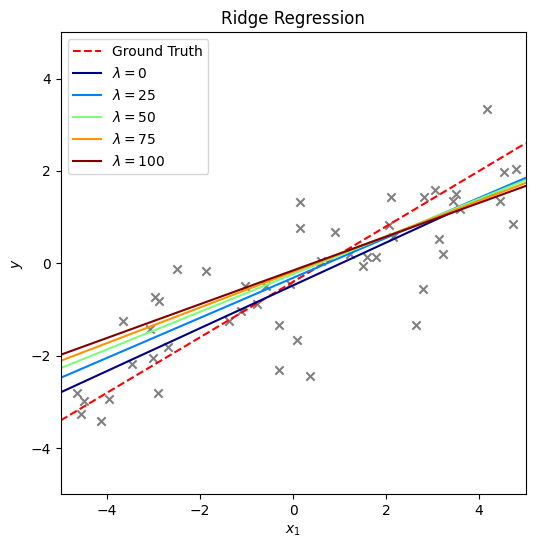

In [7]:
def plot_ridge_regression_1d ( axes, X, y, weights, limits, l2s=[0] ):
    """
    Perform least-squares fits to the provided (X, y) data
    using the specified levels of L2 regularisation, and plot
    the results.

    # Arguments
        axes: a Matplotlib Axes object into which to plot
        X: an array of sample data, where rows are samples
            and the single column is the input feature.
        y: vector of output values corresponding to the
            rows of X
        weights: a weight vector of length 2, specifying
            the true generating model, with a bias term
            at index 0.
        limits: a tuple (low, high) specifying the value
            range of the feature dimension x1
        l2s: a list (or vector/array) of numeric values
            specifying amounts of L2 regularisation to use.
    """
    assert(len(X.shape)==2)
    assert(X.shape[1]==1)
    assert(X.shape[0]==len(y))

    # plot the data
    axes.scatter(X[:,0], y, marker='x', color='grey')

    # plot the true relationship
    y0 = weights[0] + limits[0] * weights[1]
    y1 = weights[0] + limits[1] * weights[1]

    axes.plot(limits, (y0, y1), linestyle='dashed', color='red', label='Ground Truth')

    # fit for specified regs and plot the results
    X1 = utils.add_x0(X)

    cmap = matplotlib.colormaps['jet']
    for l2 in l2s:
        w = ridge_closed(X1, y, l2)

        y0 = w[0] + limits[0] * w[1]
        y1 = w[0] + limits[1] * w[1]

        axes.plot(limits, (y0, y1), linestyle='solid', color=cmap(l2/np.max(l2s)), label='$\\lambda=%.f$' % l2)

    axes.set_xlim(limits[0], limits[1])
    axes.set_ylim(limits[0], limits[1])
    axes.set_xlabel('$x_1$')
    axes.set_ylabel('$y$')

    axes.legend(loc='upper left')

    axes.set_title('Ridge Regression')

NUM_SAMPLES = 50
SIGMA = 1

fig = plt.figure(figsize=(6, 6))
axs = fig.subplots()

X, y = generate_noisy_linear(NUM_SAMPLES, WEIGHTS, SIGMA, LIMITS, shared_rng)

# note that here we are using the default l2=0, so this is unregularised OLS
w = ridge_closed(utils.add_x0(X), y)

print('true weights: %.2f, %.2f, %.2f' % (WEIGHTS[0], WEIGHTS[1], WEIGHTS[2]))

if w is None:
    print('regression not implemented')
    utils.plot_unimplemented(axs, title='Ridge Regression')
else:
    print('regressed weights: %.2f, %.2f, %.2f' % (w[0], w[1], w[2]))
    print('squared error: %.2g' % np.dot(WEIGHTS-w, WEIGHTS-w))

    print('plotting regularised least squares')
    X, y = generate_noisy_linear(NUM_SAMPLES, WEIGHTS[1:], SIGMA, LIMITS, shared_rng)
    plot_ridge_regression_1d ( axs, X, y, WEIGHTS[1:], LIMITS, np.arange(5) * 25 )


## 2.1 Map 1D feature vectors to a monomial basis

Implement the `monomial_projection_1d` function below.


In [8]:
def monomial_projection_1d ( X, degree ):
    """
    Map 1d data to an expanded basis of monomials
    up to the given degree. Note that we start
    the terms from degree 0, which is equivalent
    to adding a dummy feature x0 = 1.

    # Arguments
        X: an array of sample data, where rows are samples
            and the single column is the input feature.
        degree: maximum degree of the monomial terms

    # Returns
        Xm: an array of the transformed data, with the
            same number of rows (samples) as X, and
            with degree+1 columns (features):
            1, x, x**2, x**3, ..., x**degree
    """
    assert(len(X.shape)==2)
    assert(X.shape[1]==1)
    assert(degree >= 0)

    Xm = np.zeros((X.shape[0], degree+1))
    for i in range(degree+1):
      Xm[:,i] = X[:,0]**i
    return Xm

## 2.2 Generate noisy 1D polynomial data

NEXT I implement the function `generate_noisy_poly_1d`. This function is obviously quite similar to `generate_noisy_linear` from week 1. 

In [9]:
def generate_noisy_poly_1d ( num_samples, weights, sigma, limits, rng ):
    """
    Draw samples from a 1D polynomial model with additive
    Gaussian noise.

    # Arguments
        num_samples: number of samples to generate
            (ie, the number of rows in the returned X
            and the length of the returned y)
        weights: vector of the polynomial coefficients
            (including a bias term at index 0)
        sigma: standard deviation of the additive noise
        limits: a tuple (low, high) specifying the value
            range for the single input dimension x1
        rng: an instance of numpy.random.Generator
            from which to draw random numbers

    # Returns
        X: a matrix of sample inputs, where
            the samples are the rows and the
            single column is the 1D feature x1
            ie, its size should be:
              num_samples x 1
        y: a vector of num_samples output values
    """
    # TODO: implement this

    X = rng.uniform(limits[0], limits[1], (num_samples, 1))
    y = np.zeros(num_samples)
    for i in range(len(weights)):
      y += weights[i] * X[:, 0]**1

    y = y + rng.normal(0, sigma, num_samples)
    return X, y

In [10]:
def fit_poly_1d ( X, y, degree, l2=0 ):
    """
    Fit a polynomial of the given degree to 1D sample data.

    # Arguments
        X: an array of sample data, where rows are samples
            and the single column is the input feature.
        y: vector of output values corresponding to the inputs,
           must be same length as number of rows in X
        degree: degree of the polynomial
        l2: optional L2 regularisation weight

    # Returns
        w: the fitted polynomial coefficients
    """
    assert(len(X.shape)==2)
    assert(X.shape[1]==1)
    assert(X.shape[0]==len(y))

    Xm = monomial_projection_1d(X, degree)
    return ridge_closed( Xm, y, l2 )

true weights: [ 0.5 -0.4  0.6]
fit 1 weights: [0.30309755 0.84711138]
fit 2 weights: [ 0.55012701  0.82430649 -0.03042548]
fit 3 weights: [ 0.53248972  0.78789362 -0.02653053  0.00295879]
fit 4 weights: [ 0.31696466  0.87051696  0.06549548 -0.00655258 -0.00543241]


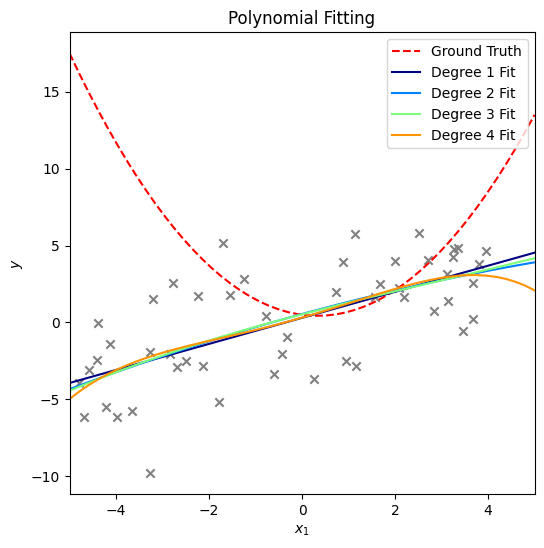

In [11]:
def plot_poly_fit_1d ( axes, X, y, weights, limits, degrees, l2=0 ):
    """
    Fit polynomials of different degrees to the supplied
    data, and plot the results.

    # Arguments
        axes: a Matplotlib Axes object into which to plot
        X: an array of sample data, where rows are samples
            and the single column is the input feature.
        y: vector of output values corresponding to the inputs,
           must be same length as number of rows in X
        weights: the true polynomial coefficients from which
           the data was generated
        limits: a tuple (low, high) specifying the value
            range of the feature dimension x1
        degrees: a list of integer values specifying degrees
            of polynomial to fit
        l2: the amount of l2 regularisation to apply

    # Returns
        None
    """
    assert(len(X.shape)==2)
    assert(X.shape[1]==1)
    assert(X.shape[0]==len(y))

    axes.scatter(X, y, color='grey', marker='x')

    print(f'true weights: {weights}')
    ground_x, ground_y = utils.grid_sample(lambda x: utils.affine(monomial_projection_1d(x, len(weights)-1), weights),
                                           1,
                                           num_divisions=50, limits=limits)

    axes.plot(ground_x, ground_y, color='red', linestyle='dashed', label='Ground Truth')

    cmap = matplotlib.colormaps['jet']
    n = 0
    for deg in degrees:
        w = fit_poly_1d(X, y, deg, l2)

        if w is None:
            print('Polynomial fitting not implemented')
            break

        print(f'fit {deg} weights: {w}')
        fit_x, fit_y = utils.grid_sample(lambda x: utils.affine(monomial_projection_1d(x, len(w)-1), w),
                                         1,
                                         num_divisions=50, limits=limits)
        axes.plot(fit_x, fit_y, linestyle='solid', color=cmap(n/len(degrees)), label=f'Degree {deg} Fit')
        n += 1

    axes.set_xlim(limits[0], limits[1])
    axes.set_xlabel('$x_1$')
    axes.set_ylabel('$y$')

    axes.legend(loc='upper right')

    axes.set_title('Polynomial Fitting')

NUM_SAMPLES = 50
SIGMA = 3

fig = plt.figure(figsize=(6, 6))
ax = fig.subplots()

X, y = generate_noisy_poly_1d ( NUM_SAMPLES, WEIGHTS, SIGMA, LIMITS, shared_rng )
if X is None:
    print('poly generation not implemented')
    utils.plot_unimplemented(ax, title='Polynomial Fitting')
else:
    plot_poly_fit_1d ( ax, X, y, WEIGHTS, LIMITS, [1, 2, 3, 4], 0 )

## 3.1 Implement a generic gradient descent optimiser

Visualising the implementation of the `gradient_descent` function in the cell below. It receives function objects for both the function to be minimised and its gradient and should repeat the process until any of the convergence criteria are reached. The returned values are lists documenting the *history* of the optimisation.



In [12]:
def gradient_descent ( z, loss_func, grad_func, lr=0.01,
                       loss_stop=1e-4, z_stop=1e-4, max_iter=100 ):
    """
    Generic batch gradient descent optimisation.
    Iteratively updates z by subtracting lr * grad
    until one or more stopping criteria are met.

    # Arguments
        z: initial value(s) of the optimisation var(s).
            can be a scalar if optimising a univariate
            function, otherwise a single numpy array
        loss_func: function of z that we seek to minimise,
            should return a scalar value
        grad_func: function calculating the gradient of
            loss_func at z. for vector z, this should return
            a vector of the same length containing the
            partial derivatives
        lr: learning rate, ie fraction of the gradient by
            which to update z each iteration
        loss_stop: stop iterating if the loss changes
            by less than this (absolute)
        z_stop: stop iterating if z changes by less than
            this (L2 norm)
        max_iter: stop iterating after iterating this
            many times

    # Returns
        zs: a list of the z values at each iteration
        losses: a list of the losses at each iteration
    """
    # TODO: implement this
    zs = [z]
    losses = [loss_func(z)]

    for i in range(max_iter):
      z_new = z - lr * grad_func(z)
      loss_new = loss_func(z_new)
      zs.append(z_new)
      losses.append(loss_new)

      if abs(losses[-1] - losses[-2]) < loss_stop:
             break
      if abs(z_new - z) < z_stop :
        break
      z = z_new
    return zs, losses

In [13]:
xx, ll = gradient_descent ( 10,
                            lambda x: x * x - 2 * x + 1,
                            lambda x: 2 * x - 2,
                            lr=0.1,
                            loss_stop=1e-6,
                            z_stop=1e-6 )

print(f'Minimum value found after {len(xx)} iterations: {xx[-1]:.4f}')
print(f'Final loss value: {ll[-1]}')

Minimum value found after 41 iterations: 1.0012
Final loss value: 1.4311461224991717e-06


In [14]:
def logistic_regression ( X, y, w0=None, lr=0.05,
                          loss_stop=1e-4, weight_stop=1e-4, max_iter=100 ):
    """
    Fit a logistic regression classifier to data.

    # Arguments
        X: an array of sample data, where rows are samples
           and columns are features. caller is responsible
           for prepending x0=1 terms if required.
        y: vector of binary class labels for the samples,
           must be same length as number of rows in X
        w0: starting value of the weights, if omitted
           then all zeros are used
        lr: learning rate, ie fraction of gradients by
           which to update weights at each iteration
        loss_stop: stop iterating if the loss changes
            by less than this (absolute)
        weight_stop: stop iterating if weights change by less
            than this (L2 norm)
        max_iter: stop iterating after iterating this
            many times

    # Returns
        ws: a list of fitted weights at each iteration
        losses: a list of the loss values at each iteration
    """
    assert(len(X.shape)==2)
    assert(X.shape[0]==len(y))

    n_samples, n_features = X.shape

    def sigmoid(z):
      return 1/(1+ np.exp(-z))

    if w0 is None:
      w = np.zeros(n_features)
    else:
      w = w0

    ws = [w.copy()]
    losses = []

    for i in range(max_iter):
      y_hat = sigmoid( X @ w )
      loss = -np.mean(y * np.log(y_hat + 1e-10) + (1 - y) * np.log(1 - y_hat + 1e-10))
      losses.append(loss)
      grad = X.T @ (y_hat - y) / n_samples #used the mean loss so we are using the mean grad too
      w_new = w - lr * grad
      ws.append(w_new.copy())

      if i > 0:
        if abs(losses[-1] - losses[-2]) < loss_stop :
          break
        if np.linalg.norm(w_new - w) < weight_stop :
          break

    w = w_new
    
    return ws, losses


Number of iterations: 2


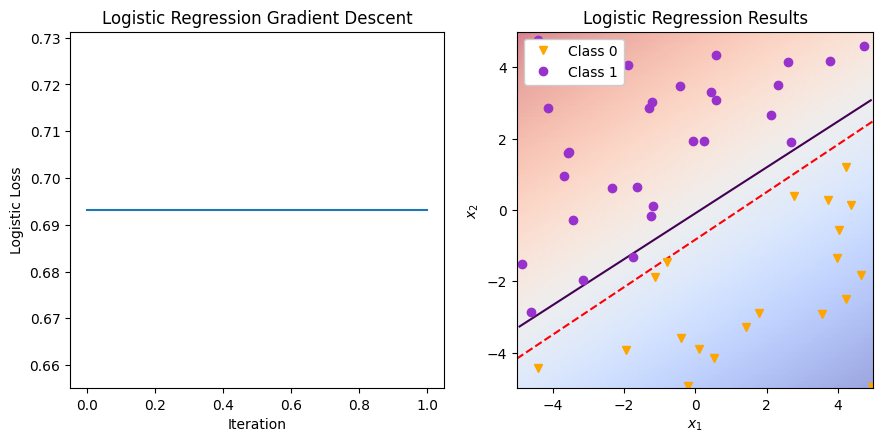

In [15]:
def plot_logistic_regression_2d ( axs, X, y, weights, limits ):
    """
    Fit a 2D logistic regression classifier and plot the results.
    Note that there are two separate plots produced here.
    The first (in axs[0]) is an optimisation history, showing how the
    loss decreases via gradient descent. The second (in axs[1]) is
    the regression itself, showing data points and fit results.

    # Arguments
        axs: an array of 2 Matplotlib Axes objects into which
           to plot.
        X: an array of sample data, where rows are samples
           and columns are features, including x0=1 terms.
        y: vector of binary class labels for the samples,
           must be same length as number of rows in X
        weights: weights defining the true decision boundary
           with which the data was generated
        limits: a tuple (low, high) specifying the value
            range of both feature dimensions

    # Returns
        None
    """
    assert(len(X.shape)==2)
    assert(X.shape[1]==3)
    assert(X.shape[0]==len(y))
    assert(len(weights)==3)

    ww, ll = logistic_regression(X, y)
    if ww is None:
        utils.plot_unimplemented(axs[0], title='Logistic Regression Gradient Descent')
        utils.plot_unimplemented(axs[1], title='Logistic Regression Results')
        return

    print('Number of iterations: %i' % len(ll))
    axs[0].plot(ll)
    axs[0].set_title('Logistic Regression Gradient Descent')
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Logistic Loss')

    Xm, ym = utils.grid_sample(lambda x: 1/(1 + np.exp(-utils.affine(x, ww[-1]))), 2, 100, limits)
    axs[1].imshow(ym.T, cmap='coolwarm', origin='lower', extent=(limits[0], limits[1], limits[0], limits[1]), alpha=0.5)
    axs[1].contour(ym.T, levels=[.5], origin='lower', extent=(limits[0], limits[1], limits[0], limits[1]))

    y0 = -(weights[0] + limits[0] * weights[1]) / weights[2]
    y1 = -(weights[0] + limits[1] * weights[1]) / weights[2]

    axs[1].plot(limits, (y0, y1), linestyle='dashed', color='red', marker='')

    axs[1].plot(X[y==0,1], X[y==0,2], linestyle='', color='orange', marker='v', label='Class 0')
    axs[1].plot(X[y==1,1], X[y==1,2], linestyle='', color='darkorchid', marker='o', label='Class 1')

    axs[1].set_xlabel('$x_1$')
    axs[1].set_ylabel('$x_2$')

    axs[1].legend(loc='upper left', framealpha=1)

    axs[1].set_title('Logistic Regression Results')


fig = plt.figure(figsize=(9, 4.5))
axs = fig.subplots(ncols=2)

NUM_SAMPLES = 50

X, y = generate_linearly_separable(NUM_SAMPLES, WEIGHTS, LIMITS, shared_rng)
X0 = utils.add_x0(X)
plot_logistic_regression_2d(axs, X0, y, WEIGHTS, LIMITS)

fig.tight_layout(pad=1)

## Implement lasso regression using gradient descent

The loss function for **lasso** ($L_1$ regularised least squares) looks like this:

$$
L(\mathbf{X, y, w}) = \|\mathbf{Xw - y}\|^2 + \lambda \| \mathbf{w} \|_1
$$

The $L_1$ norm has a corner at zero, so this function is not strictly differentiable. However, it is easy to define a **subgradient** for the norm at this point -- this could be any value in the interval $[-1, 1]$, but since this really *is* its minimum point the obvious choice is 0.

Armed with this subgradient, you should be able to implement the lasso loss and gradient functions and fit a lasso model by gradient descent. How do the results of such a fit compare with those from ridge regression?


In [16]:
def lasso_gradient_descent(X, y, lr=0.001, lamda_=0.1, max_iter=1000, tol=1e-6):
    '''
    Implementing Lasso regression as motivated in class to explore, using gradient descent with subgradiant for L1.
    '''

    n_samples, n_features = X.shape
    w = np.zeros(n_features)

    for i in range(max_iter):
        y_pred = X @ w
        error = y_pred - y

        grad = 2 * X.T @ error / n_samples
        grad += lamda_ * np.sign(w)

        w_new = w - lr * grad

        if np.linalg.norm(w_new - w) < tol:
            break

        w = w_new

    return w